# Projet AXA

## Requirement

In [2]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from datetime import datetime
import error_functions as ef
from dateutil import relativedelta
from workalendar.europe import France
# pip install workalendar
import statsmodels.api as sm
import matplotlib as mpl

/Users/Antoine/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
# colors ofr plot
blue_light = '#029aed'
orange_med = '#ff5722'
green_light = '#63a600'
gray_light = '#666666'
blue_AXA = '#103184'
red_AXA = '#ff1821'
cal = France()
# set colors for graphs
mpl.rcParams['axes.color_cycle'] = [blue_AXA, red_AXA, gray_light]

/Users/Antoine/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# create DataFrame with public holliday in France for years 2011, 2012, 2013, 2014
holiday_map = pd.DataFrame()
for year in [2011,2012,2013,2014]:
    holiday_map_temp = pd.DataFrame(cal.holidays(year))
    holiday_map_temp = holiday_map_temp.set_index([0])
    holiday_map = pd.concat([holiday_map, holiday_map_temp], ignore_index=False)
# holiday_map.head()  

## Loading data

In [5]:
# loading the train data
data = pd.read_csv('data/train.csv', sep=";", parse_dates=['DATE'], index_col = ['DATE'])#, nrows = 3*1e5)
data['DATE'] = data.index
# data.head()

/Users/Antoine/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
submission = {}
# loading the submission data
for i in range(1,13):
    print(i),
    submission[i] = pd.read_csv('documentation/Submission_data/submission_%i.txt' %i, sep="\t", parse_dates=['DATE'], index_col = ['DATE'])
    submission[i]['DATE'] = submission[i].index
    # print(submission[i].shape)
print('... OK')
# submission.head()

1 2 3 4 5 6 7 8 9 10 11 12 ... OK


## Data transformation

In [7]:
# timestamp exctraction
def splitDatetime(data) :
    datatime = pd.DatetimeIndex(data.DATE)
    data['year'] = datatime.year
    data['month'] = datatime.month
    data['day'] = datatime.day
    data['hour'] = datatime.hour
    data['min'] = datatime.minute
    data['dayweek'] = datatime.weekday
    data['workingday'] = (datatime.weekday < 6).astype(int)
    data['holiday'] = data.index.isin(holiday_map.index).astype(int)
    data['night'] = (datatime.hour < 7).astype(int)
    return data

data = splitDatetime(data)
for i in range(1,13):
    print(i),
    submission[i] = splitDatetime(submission[i])
print('... OK')
# submission.head()
# data.head()

1 2 3 4 5 6 7 8 9 10 11 12 ... OK


### Features definition

In [8]:
def format_label():
    # pivot table on data for ASS_ASSIGNMENT columnwise
    X = pd.DataFrame()
    X = data[['year','month','day','hour','ASS_ASSIGNMENT','CSPL_CALLS','min','DATE']]
    df1 = X.pivot_table(index = ['DATE'], columns = ['ASS_ASSIGNMENT'], values = ['CSPL_CALLS'], aggfunc=np.sum)
    # print(df1.shape)
    # when data for this date an categorie not available, fill with 0
    df1.fillna(0, inplace=True)
    # df1.head()

    # creating labels, ASS_ASSIGNMENT are presented columnwise thanks to pivot table above
    y_df = pd.DataFrame()
    for cat in data.ASS_ASSIGNMENT.unique() :
        y_df[cat] = df1['CSPL_CALLS'][cat]
    y_df.head()
    
    return y_df
    
y_df = format_label()

/Users/Antoine/anaconda2/lib/python2.7/site-packages/dateutil/parser.py:98: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  while nextchar == '\x00':
/Users/Antoine/anaconda2/lib/python2.7/site-packages/dateutil/parser.py:123: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif nextchar == '.':


### Decomposition Trend/Season

inferred freq : None
used freq : 336


/Users/Antoine/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


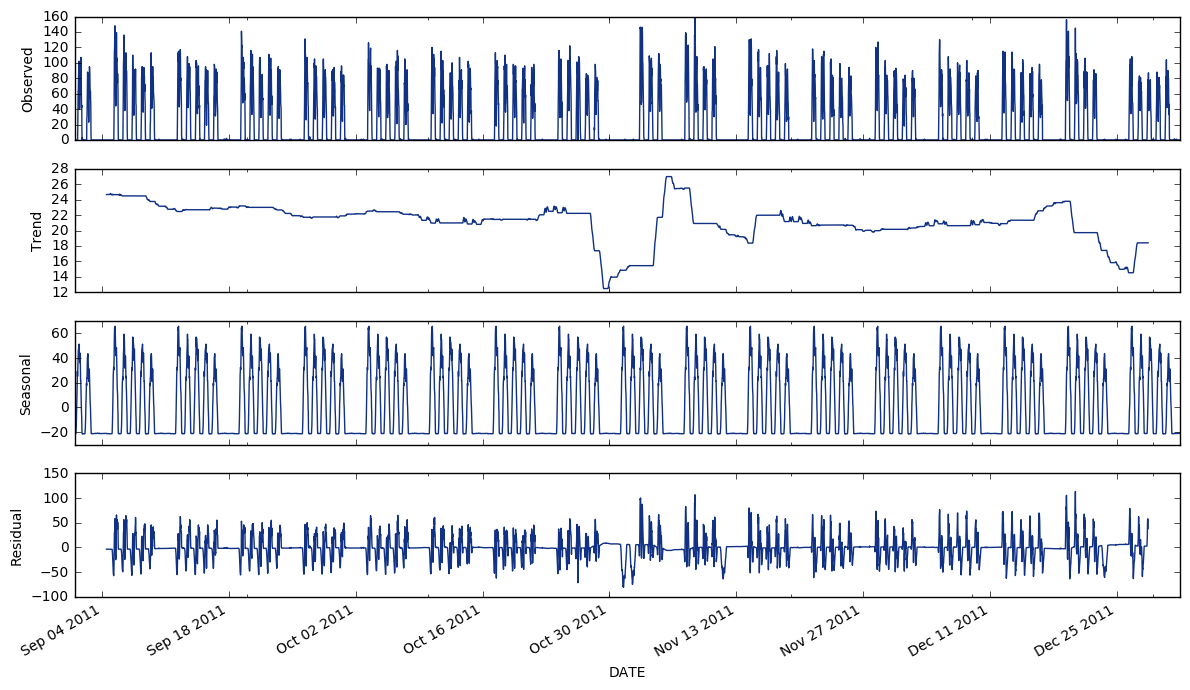

In [8]:
# trying to infer frequence (not working)
inferred_freq = y_df.index.inferred_freq
used_freq = 336
print('inferred freq : %s' %inferred_freq)
print('used freq : %s' %used_freq)


# seasonal decomposition
y_df.Nuit.interpolate(inplace=True)
decomposition = sm.tsa.seasonal_decompose(y_df['2011-09':'2011-12'].CAT, freq=used_freq)

# trend = decomposition.trend
# seasonal = decomposition.seasonal 
# residual = decomposition.resid 

# plot trend, season, resid
fig = decomposition.plot()
fig.set_size_inches(12, 7)
fig.tight_layout()
plt.style.use('ggplot')
plt.show()

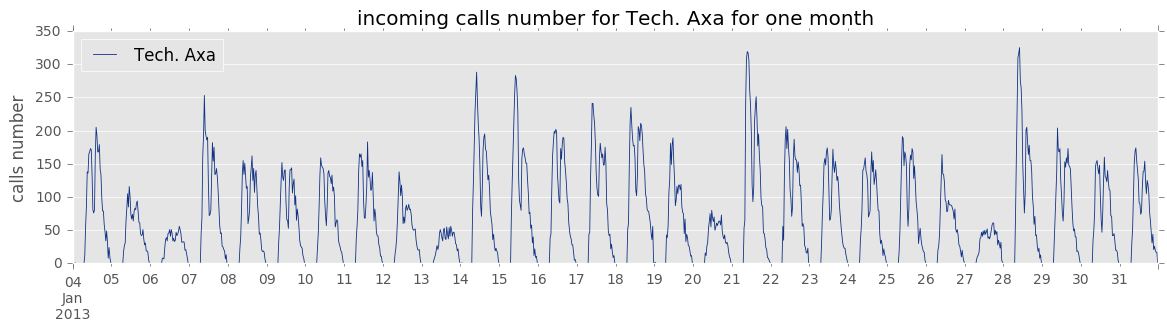

In [9]:
fig = plt.figure(figsize=[14,3])
plt.style.use('ggplot')
plot_cat = y_df['Tech. Axa']['2013-01'].plot(color=blue_AXA,linewidth=.6)
#plot_registered = X['CSPL_ACDCALLS'][periode].plot(color=blue_light,linewidth=.6)
#plot_casual = X['CSPL_ABNCALLS'][periode].plot(color=green_light,linewidth=.6)
plt.ylabel('calls number')
plt.legend(['Tech. Axa'],loc='best')
plt.title('incoming calls number for %s for one month' %'Tech. Axa')
plt.xlabel('')
plt.show()
fig.savefig('plots/appels_categorie_%s_month.png' %('Tech. Axa'),bbox_inches='tight')

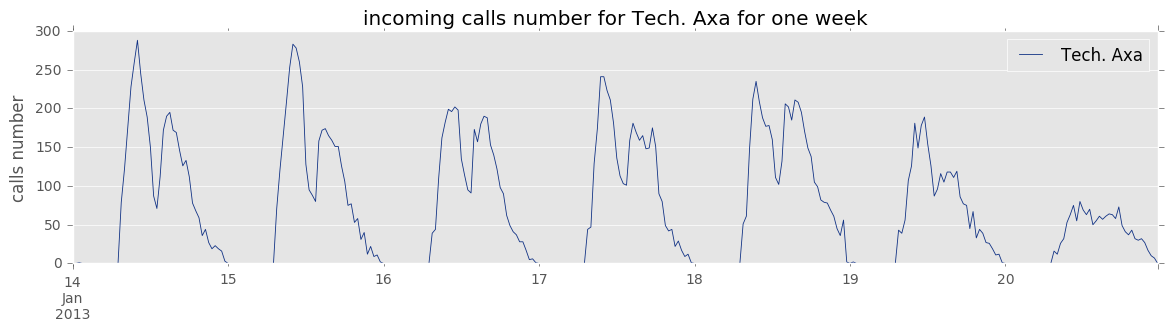

In [10]:
fig = plt.figure(figsize=[14,3])
plt.style.use('ggplot')
plot_cat = y_df['Tech. Axa']['2013-01-14':'2013-01-20'].plot(color=blue_AXA,linewidth=.6)
#plot_registered = X['CSPL_ACDCALLS'][periode].plot(color=blue_light,linewidth=.6)
#plot_casual = X['CSPL_ABNCALLS'][periode].plot(color=green_light,linewidth=.6)
plt.ylabel('calls number')
plt.legend(['Tech. Axa'],loc='best')
plt.title('incoming calls number for %s for one week' %'Tech. Axa')
plt.xlabel('')
plt.show()
fig.savefig('plots/appels_categorie_%s_week.png' %('Tech. Axa'),bbox_inches='tight')

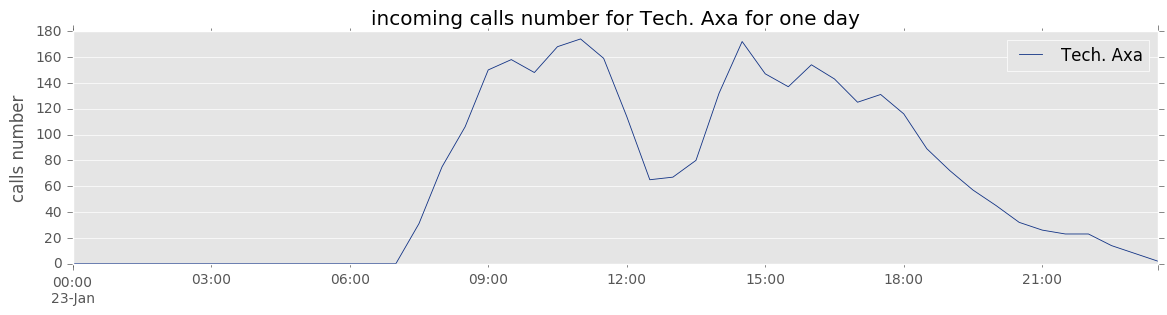

In [11]:
fig = plt.figure(figsize=[14,3])
plt.style.use('ggplot')
plot_cat = y_df['Tech. Axa']['2013-01-23'].plot(color=blue_AXA,linewidth=.6)
#plot_registered = X['CSPL_ACDCALLS'][periode].plot(color=blue_light,linewidth=.6)
#plot_casual = X['CSPL_ABNCALLS'][periode].plot(color=green_light,linewidth=.6)
plt.ylabel('calls number')
plt.legend(['Tech. Axa'],loc='best')
plt.title('incoming calls number for %s for one day' %'Tech. Axa')
plt.xlabel('')
plt.show()
fig.savefig('plots/appels_categorie_%s_day.png' %('Tech. Axa'),bbox_inches='tight')

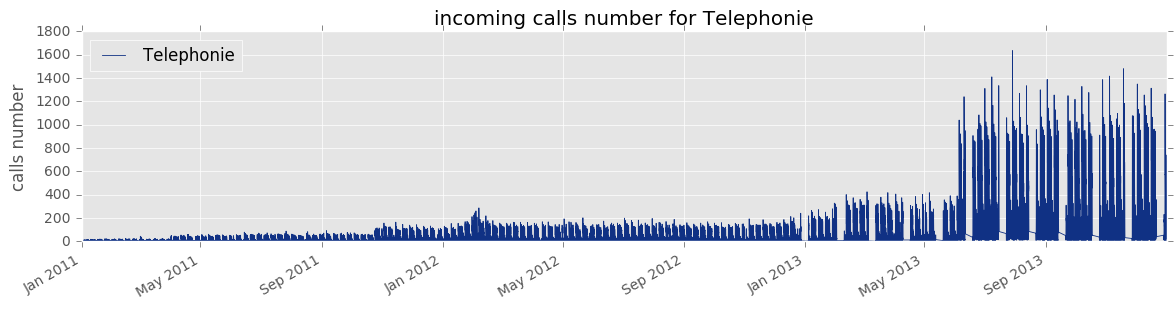

In [12]:
fig = plt.figure(figsize=[14,3])
plt.style.use('ggplot')
plot_cat = y_df['Téléphonie'].plot(color=blue_AXA,linewidth=.6)
#plot_registered = X['CSPL_ACDCALLS'][periode].plot(color=blue_light,linewidth=.6)
#plot_casual = X['CSPL_ABNCALLS'][periode].plot(color=green_light,linewidth=.6)
plt.ylabel('calls number')
plt.legend(['Telephonie'],loc='best')
plt.title('incoming calls number for %s' %'Telephonie')
plt.xlabel('')
plt.show()
fig.savefig('plots/appels_categorie_%s.png' %('Telephonie'),bbox_inches='tight')

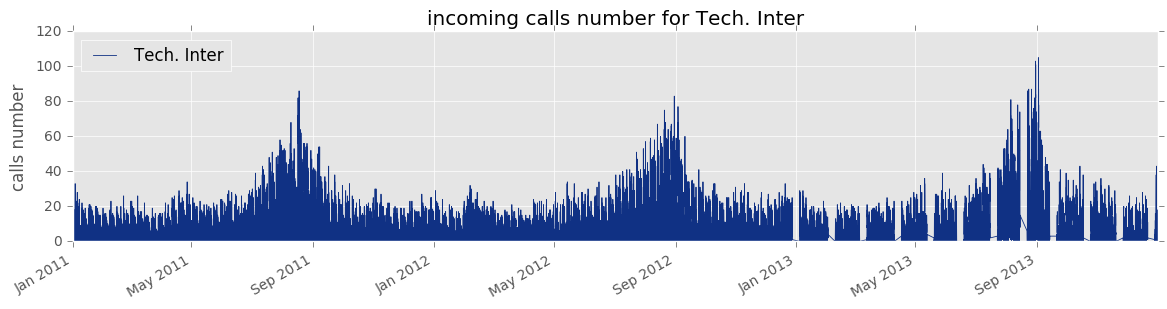

In [13]:
fig = plt.figure(figsize=[14,3])
plt.style.use('ggplot')
plot_cat = y_df['Tech. Inter'].plot(color=blue_AXA,linewidth=.6)
#plot_registered = X['CSPL_ACDCALLS'][periode].plot(color=blue_light,linewidth=.6)
#plot_casual = X['CSPL_ABNCALLS'][periode].plot(color=green_light,linewidth=.6)
plt.ylabel('calls number')
plt.legend(['Tech. Inter'],loc='best')
plt.title('incoming calls number for %s' %'Tech. Inter')
plt.xlabel('')
plt.show()
fig.savefig('plots/appels_categorie_%s.png' %('Tech. Inter'),bbox_inches='tight')

### Saving plots

In [92]:
for cat in data.ASS_ASSIGNMENT.unique() :
    fig = plt.figure(figsize=[14,3])
    plt.style.use('ggplot')
    plot_cat = y_df[cat].plot(color=blue_AXA,linewidth=.6)    
    plt.ylabel('calls number')
    plt.legend([cat.decode('utf-8')],loc='best')
    plt.title('incoming calls number for %s' %cat.decode('utf-8'))
    plt.xlabel('')
    fig.savefig('plots/global/appels_categorie_%s.png' %(cat.decode('utf-8')), bbox_inches='tight')
    plt.close(fig)

### Features definition

In [13]:
def format_subission(submission):
    
    # formating submission data
    X_test = pd.DataFrame(index = submission.index)
    X_test['DATE'] = submission.index
    X_test = splitDatetime(X_test)
    X_test.drop('DATE', axis=1, inplace=True)
    X_test = X_test.drop_duplicates()

    date_min_test = X_test.index.min()
    date_max_test = X_test.index.max()
    X_test_range = relativedelta.relativedelta(date_max_test, date_min_test)

    # print submission data total range
    print('test data first date : %s' %date_min_test)
    print('test data last date  : %s' %date_max_test)
    print('test data range : %s years, %s months and %s days\n' %(X_test_range.years, X_test_range.months,X_test_range.days))
    # X_test.head()
    
    return X_test

# X_test = format_subission()

In [14]:
def format_train():
    
    # formatting train data
    X_train = pd.DataFrame(index = y_df.index)
    X_train['DATE'] = y_df.index
    X_train = splitDatetime(X_train)
    X_train.drop('DATE', axis=1, inplace=True)
    
    date_min = X_train.index.min()
    date_max = X_train.index.max()
    X_train_range = relativedelta.relativedelta(date_max, date_min)

    # print train data range
    print('train data first date : %s' %date_min)
    print('train data last date  : %s' %date_max)
    print('train data range : %s years, %s months and %s days\n' %(X_train_range.years, X_train_range.months,X_train_range.days))
    # X_train.head()
    
    return X_train

### Cross validation split

In [15]:
# function to split data for CV purposes
# algorithm is test on last week of the randomly choosen train data set

def split_data(X_train):
    
    X_train_split = X_train
    # the subset contain at leat 50% of the original data
    s = np.random.uniform(X_train_split.shape[0]*0.9,X_train_split.shape[0],1).astype(int)
    X_train_split.drop(X_train_split.index[s:], inplace=True)

    date_min = X_train.index.min()
    date_max = X_train.index.max()
    X_train_range = relativedelta.relativedelta(date_max, date_min)

    # print subset range
    print('train data first date : %s' %date_min)
    print('train data last date  : %s' %date_max)
    print('train data range : %s years, %s months and %s days\n' %(X_train_range.years, X_train_range.months,X_train_range.days))
    # X_train.head()
    
    # Last week of the subset is used for cross validation purposes
    X_train_split_CV = X_train_split.last('7d')
    date_min_CV = X_train_split_CV.index.min()
    date_max_CV = X_train_split_CV.index.max()
    X_CV_range = relativedelta.relativedelta(date_max_CV, date_min_CV)

    # print CV subset week range
    print('CV data first date : %s' %date_min_CV)
    print('CV data last date  : %s' %date_max_CV)
    print('CV data range : %s years, %s months and %s days' %(X_CV_range.years, X_CV_range.months,X_CV_range.days))
    # X_train_CV.head()
    
    return X_train_split, X_train_split_CV


### Removing data anterior to prediction

In [16]:
def remove_ant(X_train, X_test, y_df):

    # removing data from train set anterior to data of the submission file
    date_min_test = X_test.index.min()
    X_train = X_train.truncate(after=date_min_test)
    y_df = y_df.truncate(after=date_min_test)

    date_min = X_train.index.min()
    date_max = X_train.index.max()
    X_train_range = relativedelta.relativedelta(date_max, date_min)

    # printing range of data after removing non-causal data
    print('train data first date : %s' %date_min)
    print('train data last date  : %s' %date_max)
    print('train data range : %s years, %s months and %s days\n' %(X_train_range.years, X_train_range.months,X_train_range.days))
    
    return X_train, y_df

### Adding features from last week

/!\ function can take a few min to execute !!

In [1]:
def add_features(X_train, y_df):
    
    # Set number of hours prediction is in advance
    n_periods_advance = 336

    # Set number of historic hours used
    n_periods_window = 1

    for cat in y_df:
        if cat not in ['Evenements','Gestion Amex']:
            for k in range(n_periods_advance,n_periods_advance+n_periods_window):
                # X_test['%s_t-%i'%(cat.decode('utf-8'),k)] = y_df[cat].shift(k*30, freq='min')
                X_train['%s_t-%i'%(cat.decode('utf-8'),k)] = y_df[cat].shift(k, freq='min')

    # remove raw following week without data
    y_df.drop(X_train[pd.isnull(X_train).any(axis=1)].index, inplace=True)
    X_train.drop(X_train[pd.isnull(X_train).any(axis=1)].index, inplace=True)

    return X_train, y_df

#X_train, y_df = add_features()

## Feature extractor

In [20]:
import numpy as np
import pandas as pd
from sklearn import preprocessing as pre

class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_df):
        pass
    
    def transform(self, X_df):
        return X_df

## Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import xgboost as xgb
from sklearn.svm import SVC, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest

#from xgboost import plot_importance

class Regressor(BaseEstimator):
    def __init__(self):
        
        self.n_components = 20
        pca = PCA(n_components=self.n_components)
        selection = SelectKBest(k = 5)
        combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
        
        self.reg = Pipeline([
            #('cf', combined_features),
            #('pca', PCA(n_components = self.n_components)),
            ('xgb', xgb.XGBRegressor(
                learning_rate = 0.1,
                n_estimators = 100,
                max_depth = 2,
                min_child_weight = 1,
                gamma = 0.2,
                subsample = 0.9,
            ))
        ])

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)
    
    def predict_proba(self, X):
        return self.reg.predict_proba(X)
    
    def grid_search_fit(self, X, y):
        y = y.astype(float)
        # use a full grid over all parameters
        param_grid = dict(
            # pca__n_components = [10,20,40],
            xgb__max_depth = [3,10,2],#[10,11,9]#[9,10,11],#
            xgb__min_child_weight = [1,6,2],
            # xgb__gamma = [i/10.0 for i in range(0,5)]
            # xgb__subsample = [i/10.0 for i in range(6,10)],
            # xgb__colsample_bytree = [i/10.0 for i in range(6,10)]
            )

        param_grid_rfr = dict(
            max_leaf_nodes = [9,10,11],
            max_depth = [3, None],
            max_features = [1, 3, 10],
            min_samples_split = [3, 10],
            min_samples_leaf = [1, 3, 10],
            bootstrap = [True, False]
            )

        # error definition
        linex = make_scorer(ef.linex_loss, greater_is_better = False)

        grid_search = GridSearchCV(self.reg, param_grid = param_grid, scoring = linex)#, verbose = 10)

        # fit gridsearch
        self.reg = grid_search.fit(X, y)

        print('Grid search  best score: %.3f' % grid_search.best_score_)
        print('Grid search  best params:')
        for k, v in sorted(grid_search.best_params_.items()):
            print("\t%s: %r" % (k, v))
        # get best estimator
        self.reg = grid_search.best_estimator_

from sklearn.base import BaseEstimator
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

class Regressor(BaseEstimator):
    def __init__(self):
        
        self.n_components = 40
        
        self.reg_day = Pipeline([
            ('pca', PCA(n_components = self.n_components)),
            ('xgb', xgb.XGBRegressor(
                learning_rate = 0.1,
                n_estimators = 100,
                max_depth = 2,
                min_child_weight = 1,
                gamma = 0.2,
                subsample = 0.9,
            ))
        ])
        
        self.reg_night = Pipeline([
            ('pca', PCA(n_components = self.n_components)),
            ('xgb', xgb.XGBRegressor(
                learning_rate = 0.1,
                n_estimators = 100,
                max_depth = 2,
                min_child_weight = 1,
                gamma = 0.2,
                subsample = 0.9,
            ))
        ])
        
        # self.reg_day = xgb.XGBRegressor(learning_rate = 0.1, n_estimators = 100, max_depth = 2, min_child_weight = 1, gamma = 0.2, subsample = 0.9)
        # self.reg_night = xgb.XGBRegressor(learning_rate = 0.1, n_estimators = 100, max_depth = 2, min_child_weight = 1, gamma = 0.2, subsample = 0.9)

    def fit(self, X, y):
        is_day = np.array(X.night == 0)
        self.reg_day.fit(X[is_day], y[is_day])
        self.reg_night.fit(X[~is_day], y[~is_day])

    def predict(self, X, cat):
        is_day = np.array(X.night == 0)
        res = np.zeros(X.shape[0])
        
        # to write submission file, X size = 1
        # Specific case to avoid array of bool beeing interpreted as bool
        if (is_day.size == 1):
            if is_day:
                res = self.reg_day.predict(X)
            if ~is_day:
                res = self.reg_night.predict(X)
        else:     
            day_pred = self.reg_day.predict(X[is_day])
            night_pred = self.reg_night.predict(X[~is_day])
            res[is_day] = day_pred
            res[~is_day] = night_pred
            
        return res
    
    def predict_proba(self, X):
        return self.reg.predict_proba(X)
    
    def grid_search_fit(self, X, y):
        param_grid = dict(
            xgb__n_estimators = [100, 200, 400],
            xgb__learning_rate = [i/10.0 for i in range(0,5)]
            # pca__n_components = [10,20,40],
            # xgb__max_depth = [3,10,2],#[10,11,9]#[9,10,11],#
            # xgb__min_child_weight = [1,6,2],
            # xgb__gamma = [i/10.0 for i in range(0,5)]
            # xgb__subsample = [i/10.0 for i in range(6,10)],
            # xgb__colsample_bytree = [i/10.0 for i in range(6,10)]
            )

        # error definition
        linex = make_scorer(ef.linex_loss, greater_is_better = False)
        
        # perform grid search
        grid_search_day = GridSearchCV(self.reg_day, param_grid = param_grid, scoring = linex)#, verbose = 10)
        grid_search_night = GridSearchCV(self.reg_night, param_grid = param_grid, scoring = linex)#, verbose = 10)

        # fit gridsearch
        is_day = np.array(X.night == 0)
        self.reg_day = grid_search_day.fit(X[is_day], y[is_day])
        self.reg_night = grid_search_night.fit(X[~is_day], y[~is_day])

        print('\t Grid search day best score: %.3f' % grid_search_day.best_score_)
        print('\t Grid search day best params:')
        for k, v in sorted(grid_search_day.best_params_.items()):
            print("\t \t%s: %r" % (k, v))
        # get best estimator
        self.reg_day = grid_search_day.best_estimator_
        
        print('\t Grid search night best score: %.3f' % grid_search_night.best_score_)
        print('\t Grid search night best params:')
        for k, v in sorted(grid_search_night.best_params_.items()):
            print("\t \t%s: %r" % (k, v))
        # get best estimator
        self.reg_day = grid_search_night.best_estimator_

 def grid_search_fit(self, X, y):
        param_grid = dict(
            xgb__n_estimators = [100, 200, 400],
            xgb__learning_rate = [i/10.0 for i in range(0,5)],
            # pca__n_components = [10,20,40],
            xgb__max_depth = [3,10,2],#[10,11,9]#[9,10,11],#
            # xgb__min_child_weight = [1,6,2],
            # xgb__gamma = [i/10.0 for i in range(0,5)]
            # xgb__subsample = [i/10.0 for i in range(6,10)],
            # xgb__colsample_bytree = [i/10.0 for i in range(6,10)]
            )

        # error definition
        linex = make_scorer(ef.linex_loss, greater_is_better = False)

        # perform grid search
        grid_search_high = GridSearchCV(self.reg_high, param_grid = param_grid, scoring = linex)#, verbose = 10)
        grid_search_high_2 = GridSearchCV(self.reg_high_2, param_grid = param_grid, scoring = linex)#, verbose = 10)

        # fit gridsearch
        is_high = np.array(y > 200)
        is_high_2 = np.array(y > 800)
        self.reg_high = grid_search_high.fit(X[is_high], np.log(y[is_high]))
        self.reg_high_2 = grid_search_high_2.fit(X[is_high_2], np.log(y[is_high_2]))

        print('\t Grid search high best score: %.3f' % grid_search_high.best_score_)
        print('\t Grid search high best params:')
        for k, v in sorted(grid_search_high.best_params_.items()):
            print("\t \t%s: %r" % (k, v))
        # get best estimator
        self.reg_high = grid_search_high_2.best_estimator_

        print('\t Grid search high_2 best score: %.3f' % grid_search_high_2.best_score_)
        print('\t Grid search high_2 best params:')
        for k, v in sorted(grid_search_high_2.best_params_.items()):
            print("\t \t%s: %r" % (k, v))
        # get best estimator
        self.reg_high_2 = grid_search_high_2.best_estimator_

In [18]:
from sklearn.base import BaseEstimator
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

class Regressor(BaseEstimator):
    def __init__(self):
        
        self.n_components = 40
        self.reg_std = Pipeline([
            # ('pca', PCA(n_components = self.n_components)),
            ('xgb', xgb.XGBRegressor(
                learning_rate = 0.1,
                n_estimators = 100,
                max_depth = 2,
                min_child_weight = 1,
                gamma = 0.2,
                subsample = 0.9,
            ))
        ])
        
        self.reg_high = Pipeline([
            # ('pca', PCA(n_components = self.n_components)),
            ('xgb', xgb.XGBRegressor(
                learning_rate = 0.1,
                n_estimators = 100,
                max_depth = 2,
                min_child_weight = 1,
                gamma = 0.1,
                subsample = 0.9,
            ))
        ])

        self.reg_high_2 = Pipeline([
            # ('pca', PCA(n_components = self.n_components)),
            ('xgb', xgb.XGBRegressor(
                learning_rate = 0.1,
                n_estimators = 100,
                max_depth = 2,
                min_child_weight = 1,
                gamma = 0.1,
                subsample = 0.9,
            ))
        ])
        
    def fit(self, X, y):
        is_high = np.array(y > 800)
        is_high_2 = np.array(y > 1100)
        self.reg_std.fit(X, y)
        if any(is_high):
            self.reg_high.fit(X[is_high], np.log(y[is_high]))
        if any(is_high_2):
            self.reg_high_2.fit(X[is_high_2], np.log(y[is_high_2]))

    def predict(self, X, cat):
        res = np.zeros(X.shape[0])
        res = self.reg_std.predict(X)
        if cat in ['CAT', 'Tech. Axa','Téléphonie']:
            # print('(using specific module for high values)')
            is_high = res > 750
            if any(is_high):
                res[is_high] = np.exp(self.reg_high.predict(X[is_high]))
            is_high_2 = res > 1050
            if any(is_high_2):
                res[is_high_2] = np.exp(self.reg_high.predict(X[is_high_2]))
        return res
    
    def predict_proba(self, X):
        return self.reg.predict_proba(X)

## Cross validation Module

In [54]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Regressor, GS):
    
    y_train_reg = {}
    y_test_reg = {}
    reg = {}
    y_pred_reg = {}
    error = 0
    
    for cat in data.ASS_ASSIGNMENT.unique():
        #print('%s' %cat.decode('utf-8'))
        if cat in ['Téléphonie']:
        #if cat not in ['Evenements','Gestion Amex']:
            #print('------------------------------------------------')
            # Spliting data for cross validation
            train_is, test_is = skf_is
            
            # test/train definition
            X_train_df = X_df.iloc[train_is].copy()
            # for prediction only use general features such as date and time and category last week data
            #base_col = ['year','month','day','hour','min','workingday','holiday','weekday','night']
            #filter_col = [col for col in list(X_train_df) if (col.startswith(cat.decode('utf-8')) or col in base_col)]
            #X_train_df = X_train_df[filter_col]
            y_train_df = y_df.iloc[train_is].copy()
            #y_pred_df = y_df.iloc[test_is].copy()
            X_test_df = X_df.iloc[test_is].copy()
            #X_test_df = X_test_df[filter_col]
            y_test_df = y_df.iloc[test_is].copy()
            
            
            # for téléphonie only use last 6 month because data range to vary a lot each year
            if cat in ['Téléphonie','Tech. Axa','CAT']: #'Tech. Axa','CAT'
                X_train_df = X_train_df.last('3m')
                y_train_df = y_train_df.last('3m')

            # label category definition
            y_train_reg[cat] = y_train_df[cat].values
            y_test_reg[cat] = y_test_df[cat].values
            #y_pred_df[cat]  = y_test_df[cat].values
            # y_test_reg = y_test_df['count'].values
            #print("Done.")

            # Features extraction (no modification of data in this case)
            #print("Exctracting features ..."),
            fe_reg = FeatureExtractor()
            fe_reg.fit(X_train_df, y_train_df)
            X_train_array_reg = fe_reg.transform(X_train_df)
            X_test_array_reg = fe_reg.transform(X_test_df)
            #print("Done.")

            # Train
            # regressors initialisation
            reg[cat] = Regressor()

            # grid search to calibrate model before fitting (if set to True in function)
            if GS :
                if cat in ['Tech. Axa','Téléphonie','CAT']:
                    reg[cat].grid_search_fit(X_train_array_reg, y_train_reg[cat])

            # fitting model
            #print("Training algorithm for %s..." %cat.decode('utf-8')),
            reg[cat].fit(X_train_array_reg, y_train_reg[cat])
            #print("Done.")

            # Test
            #print("Testing algorithm for %s..." %cat.decode('utf-8')),
            y_pred_reg[cat] = np.round(np.maximum(reg[cat].predict(X_test_array_reg,cat),0),0)
            
            #if  np.all(y_train_df[cat].shift(7, freq='d').index.isin(y_pred_df[cat].index)) :
            #y_pred_df[cat]  = np.fmax(y_train_df[cat].shift(7, freq='d'),y_train_df[cat].shift(1, freq='A'))
            #y_pred_df[cat]  = np.fmax(y_train_df[cat].shift(14, freq='d'),y_pred_df[cat])
            #else:
            #    y_pred_df[cat]  = np.maximum(y_train_df[cat].shift(14, freq='d'),y_train_df[cat].shift(1, freq='A'))

            y_pred_reg[cat] = y_pred_df[cat].values
            
            error_tmp = ef.linex_loss(y_pred_reg[cat], y_test_reg[cat])
            error += error_tmp

            #print("Done.")
            print('error %s = %.1f' %(cat.decode('utf-8'),error_tmp))
            
            # plot figure for predicted week
            y_test_plt = pd.DataFrame(index = y_test_df.index)
            y_test_plt[cat.decode('utf-8')] = y_test_reg[cat]
            y_pred_plt = pd.DataFrame(index = y_test_df.index)
            y_pred_plt[cat.decode('utf-8')] = y_pred_reg[cat]
            
            fig = plt.figure(figsize=[15,4])
            plt.style.use('ggplot')
            plt.plot(y_test_plt[cat.decode('utf-8')], color = blue_AXA)
            plt.plot(y_pred_plt[cat.decode('utf-8')], linestyle = 'dashed', color=red_AXA, linewidth=2)
            plt.title('error on predected week for %s (error = %.1f)' %(cat.decode('utf-8'),error_tmp))
            plt.legend(['true','pred'],loc='best')
            fig.savefig('plots/Pred_appels_categorie_%s.png' %(cat),bbox_inches='tight')
            
            #print('\n------------------------------------------------')
        #else:
            #print("pass.")
            #print('------------------------------------------------')
    k = X_train_df.shape[0]+X_test_df.shape[0]
    l = X_train_df.shape[0]
    print('train sample size %% total sample size = %.2f%%' %(100*float(l)/k))
    print('error = %.1f' %(error))

# splitting sample for CV : 
# take a radom part of the train sample (at least 50% of the original data size) and the last week to test results
X_train = format_train()
X_train, y_df = add_features(X_train, y_df)
X_train_1, X_train_CV = split_data(X_train)
X_train_1 = pd.get_dummies(data=X_train_1, columns=['year', 'month','day','hour','min','dayweek'])
X_train_CV = pd.get_dummies(data=X_train_CV, columns=['year', 'month','day','hour','min','dayweek'])
a = X_train_1.shape[0]
b = X_train_CV.shape[0]
skf_is = ([np.arange(a-b).astype(int),np.arange(a-b,a).astype(int)])

train_test_model_clf(X_train_1, y_df, skf_is, FeatureExtractor, Regressor, False)

train data first date : 2011-01-03 20:00:00
train data last date  : 2013-12-31 23:30:00
train data range : 2 years, 11 months and 28 days

train data first date : 2011-01-03 22:00:00
train data last date  : 2013-12-15 07:30:00
train data range : 2 years, 11 months and 11 days

CV data first date : 2013-12-08 08:00:00
CV data last date  : 2013-12-15 07:30:00
CV data range : 0 years, 0 months and 6 days


ValueError: operands could not be broadcast together with shapes (2635,) (336,) 

## Submission prediction

In [60]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def train_test_model_clf(X_train, X_test, y_train, FeatureExtractor, submission, sub_i):
    
    y_train_reg = {}
    y_test_reg = {}
    reg = {}
    y_pred_reg = {}
    error = 0
    y_pred = np.zeros((submission.shape[0]))
    
    for cat in submission.ASS_ASSIGNMENT.unique():
        print('%s' %cat.decode('utf-8'))
        if cat not in ['Evenements','Gestion Amex']:
            print('------------------------------------------------')

            # test/train definition  
            X_train_df = X_train.copy()
            y_train_df = y_train.copy()
            X_test_df = X_test.copy()
            
            #base_col = ['year','month','day','hour','min','workingday','holiday','weekday','night']
            #filter_col = [col for col in list(X_train_df) if (col.startswith(cat.decode('utf-8')) or col in base_col)]          
            #X_test_df = X_test_df[filter_col]
            #X_train_df = X_train_df[filter_col]
            
            if cat in ['Téléphonie','Tech. Axa','CAT']: #'Tech. Axa','CAT'
                X_train_df = X_train_df.last('3m')
                y_train_df = y_train_df.last('3m')

            # cat definition
            y_train_reg[cat] = y_train_df[cat].values
            print("Done.")

            # Features extraction (no modification of data in this case)
            print("Exctracting features ..."),
            fe_reg = FeatureExtractor()
            fe_reg.fit(X_train_df, y_train_df)
            X_train_array_reg = fe_reg.transform(X_train_df)
            X_test_array_reg = fe_reg.transform(X_test_df)
            print("Done.")

            # Train
            print("Training algorithm for %s..." %cat.decode('utf-8')),
            # regressors initialisation
            reg[cat] = Regressor()
            print('...'),

            # uncomment to perform grid search to calibrate model before fitting
            #if cat in ['Tech. Axa','Téléphonie','CAT']:
            #    reg[cat].grid_search_fit(X_train_array_reg, y_train_reg[cat])

            # fitting model
            reg[cat].fit(X_train_array_reg, y_train_reg[cat])            
            print("Done.")
            print('\n------------------------------------------------')
        else:
            print("pass.")
            print('------------------------------------------------')
    
    rep = pd.DataFrame(index = submission.index)
    rep['DATE'] = submission.index
    rep['ASS_ASSIGNMENT'] = submission.ASS_ASSIGNMENT
    i = 0
    
    for index, row in rep.iterrows():
        cat = row['ASS_ASSIGNMENT']
        y_pred[i] = reg[cat].predict(X_test.loc[index], cat)[0].astype(int)
        i+=1
    rep['prediction'] = np.maximum(y_pred.astype(int),0)
    #rep['DATE'] = [dd + ".000" for dd in rep['DATE']]
    print("saved in file")
    
    rep.to_csv("documentation/Submission_data/submission_test_%i.txt" %sub_i, sep="\t", index=False)

X_test = {}
X_train_sub = {}
y_df_sub = {}

X_train = format_train()
for k in range (1,12):
    print(k)
    # formating data from the submission file
    X_test[k] = format_subission(submission[k])
    # removing data from the train set anterior to data from submission set
    X_train_sub[k], y_df_sub[k] = remove_ant(X_train, X_test[k], y_df)
    X_train_sub[k] = pd.get_dummies(data=X_train_sub[k], columns=['year', 'month','day','hour','min','dayweek'])
    train_test_model_clf(X_train_sub[k], X_test[k], y_df_sub[k], FeatureExtractor, submission[k], k)

train data first date : 2011-01-01 00:00:00
train data last date  : 2013-12-31 23:30:00
train data range : 2 years, 11 months and 30 days

1
test data first date : 2012-12-28 00:00:00
test data last date  : 2013-01-03 23:30:00
test data range : 0 years, 0 months and 6 days

train data first date : 2011-01-01 00:00:00
train data last date  : 2012-12-27 23:30:00
train data range : 1 years, 11 months and 26 days

CMS
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for CMS... ... Done.

------------------------------------------------
Crises
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Crises... ... Done.

------------------------------------------------
Domicile
------------------------------------------------
Done.
Exctracting features ... Done.
Training algorithm for Domicile... ... Done.

------------------------------------------------
Gestion
----------------------

In [61]:
# data_files = ['file2.csv', 'file3.csv']
df = pd.read_csv('documentation/Submission_data/submission_1.txt')
#for el in data_files:
for i in range(2,13):
    df_tmp = pd.read_csv('documentation/Submission_data/submission_%i.txt' %i)    
    df = df.append(df_tmp)
    # print(df.shape)
df.to_csv('documentation/Submission_data/submission_test.txt', index = False)

In [62]:
input_file = "submission_test.txt"
output_file = "submission_test_modif.txt"

modif = pd.read_csv(input_file, sep="\t")
print("File read.")
modif['DATE'] = [dd + ".000" for dd in modif['DATE']]
print("Data modified.")
modif.to_csv(output_file, sep="\t", index=False)
print("All done.")


File read.
Data modified.
All done.
